# Lagrange codebook optimization

## Setup

In [1]:
import time
import json

import numpy as np

import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from cissir import visualization as viz
viz.paper_style(line_cycler=False, figsize=(1.5 * viz.def_figsize[0], 1.5 * viz.def_figsize[1]))

from sionna.rt import Antenna

from pathlib import Path
from cissir.physics import pow2db, db2power, mag2db, db2mag
from cissir.raytracing import si_paths2cir

from cissir import params, optimization as opt
from cissir.beamforming import dft_codebook, plot_beamforming_polar
from cissir.utils import PrintBuffer

base_path = Path.cwd().parent
plot_path = base_path/"plots"
res_path = base_path/"results"

opt.compile_coeff_code()

Compiling `sigma_poly_coeffs_toeplitz` function...
Function compiled. time elapsed: 2.693 s


In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m


ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams
L_r = params.num_beams
L_t = params.num_beams

### DFT beam codebook


In [3]:
dft_tx_codebook, tx_degs = dft_codebook(L_max = L_t , N1 = N_t, full_grid=True,
                                          az_min = -60, az_max = 60, transmit=True)
L_t = len(tx_degs)
dft_rx_codebook, rx_degs = dft_codebook(L_max = L_r , N1 = N_r, full_grid=True,
                                          az_min = -60, az_max = 60, transmit=False)
L_r = len(rx_degs)

In [20]:
si_num_taps = 1 # "full"    # Options: 1, 2, "full"

def cb_si_db(tx_codebook, rx_codebook, si_channel):
    return mag2db(opt.codebook_si(tx_codebook, rx_codebook, si_channel))

with np.load(res_path/"channel_impulse_responses.npz") as rt_data:
    t_rt = np.squeeze(rt_data['t_channel_s'])
    ht_si_full = np.squeeze(rt_data['ht_si'])
    h_full = si_paths2cir(ht_si_full)

if si_num_taps == "full":
    h_si = h_full
    si_db_ref = cb_si_db(dft_tx_codebook, dft_rx_codebook, h_si).max()
else:
    with np.load(res_path/"si_mimo.npz") as rt_data:
        h_si = rt_data['h_si_matrix'][:si_num_taps]
    si_db_ref = cb_si_db(dft_tx_codebook, dft_rx_codebook,
                         si_paths2cir(ht_si_full[:si_num_taps])).max()
    h_si *= db2mag(si_db_ref - cb_si_db(dft_tx_codebook, dft_rx_codebook, h_si).max())
    
    assert h_si.shape == (si_num_taps, N_r, N_t), "Unexpected SI shape"

In [21]:
h_si_rx, h_si_tx = opt.si_split(h_si)

min_eigval_db = mag2db(opt.min_eigval(h_si))
max_eigval_db = mag2db(opt.max_eigval(h_si))

min_split_db = pow2db(opt.min_eigval(h_si_rx)*opt.min_eigval(h_si_tx))
max_split_db = pow2db(opt.max_eigval(h_si_rx)*opt.max_eigval(h_si_tx))
lagrange_feas_db = pow2db(opt.feasible_eigval_lagrange(dft_rx_codebook, h_si_rx).max() *
                          opt.feasible_eigval_lagrange(dft_tx_codebook, h_si_tx).max())
max_att = si_db_ref - lagrange_feas_db

In [22]:
print(f"      eig_min H: {min_eigval_db:.1f} dB")
print(f"eig_min Grx\Gtx: {min_split_db:.1f} dB")
print(f"Lagrange feas. : {lagrange_feas_db:.1f} dB")
print(f"            cHw: {si_db_ref:.1f} dB")
print(f"      eig_max H: {max_eigval_db:.1f} dB")
print(f"eig_max Grx\Gtx: {max_split_db:.1f} dB")

      eig_min H: -173.9 dB
eig_min Grx\Gtx: -177.3 dB
Lagrange feas. : -165.5 dB
            cHw: -60.6 dB
      eig_max H: -41.9 dB
eig_max Grx\Gtx: -41.4 dB


## Optimization

In [23]:
tgt_si_values = np.arange(si_db_ref, lagrange_feas_db + 0.5, -1.0)
pbuf = PrintBuffer(print_input=False)

In [24]:
rx_mesh, tx_mesh = np.meshgrid(rx_degs, tx_degs, indexing="ij")
beam_results = {"opt": "sdr",
                "taps": si_num_taps,
                "tx": {"degrees": tx_degs.tolist(),
                       "grid": tx_mesh.flatten().tolist()},
                "rx": {"degrees": rx_degs.tolist(),
                       "grid": rx_mesh.flatten().tolist()},
                "tgt_si": [],
                "ach_si": [],
                "beam_dev_tx": [],
                "beam_dev_rx": []
                }

results = []
codebooks = []

phased_array = False


pbar = tqdm(tgt_si_values)
pbar.set_description(f"Baseline SI {si_db_ref:.1f} dB")
for tgt_si_db in pbar:
    
    # att_db = -tgt_si_db
    tgt_si_pow = db2power(tgt_si_db)
    
    q = 0.5
    tgt_si_tx, tgt_si_rx = tgt_si_pow ** q, tgt_si_pow ** (1-q)

    pbuf.print(f"Tgt. SI. {tgt_si_db:.1f} dB")
    
    start_time = time.perf_counter()
    w_codebook = opt.lagrange_codebook(dft_tx_codebook, tgt_si_tx, h_si_tx, si_tol=0.01, real_tol=1e-3)
    c_codebook = opt.lagrange_codebook(dft_rx_codebook, tgt_si_rx, h_si_rx, si_tol=0.01, real_tol=1e-3)
    end_time = time.perf_counter()
    
    si_db_matrix = cb_si_db(w_codebook, c_codebook, h_si)
    si_db_opt = np.max(si_db_matrix)
    
    tx_dev_beam = np.maximum(opt.codebook_deviation_power(dft_tx_codebook, w_codebook, axis=0), 1e-10)
    rx_dev_beam = np.maximum(opt.codebook_deviation_power(dft_rx_codebook, c_codebook, axis=0), 1e-10)
    loss_w_opt = pow2db(np.mean(tx_dev_beam))
    loss_c_opt = pow2db(np.mean(rx_dev_beam))
    
    # att_rank1 = -si_db_opt
    pbuf.print("Solutions SDR\\Rank-1:")
    pbuf.print(f"\t\tMax. SI :\t{si_db_opt:.1f} dB")
    pbuf.print(f"\t\tTx error:\t{loss_w_opt:.1f} dB")
    pbuf.print(f"\t\tRx error:\t{loss_c_opt:.1f} dB")

    tx_beam_db = pow2db(tx_dev_beam)
    rx_beam_db = pow2db(rx_dev_beam)
    
    postfix = (f"SI Tgt::Actual {tgt_si_db:.1f}::{si_db_opt:.1f} dB; "
               f"Error Tx::Rx {loss_w_opt:.1f}::{loss_c_opt:.1f} dB")
    pbar.set_postfix_str(postfix)

    if si_num_taps == "full":
        si_db_full = si_db_opt
    else:
        si_db_full = mag2db(np.max(opt.codebook_si(w_codebook, c_codebook, h_full)))

    beam_results["tgt_si"].append(tgt_si_db)
    beam_results["ach_si"].append(si_db_matrix.flatten().tolist())
    beam_results["beam_dev_tx"].append(tx_beam_db.tolist())
    beam_results["beam_dev_rx"].append(rx_beam_db.tolist())
    
    codebooks.append({"si_tgt": tgt_si_db, "si_opt": si_db_opt, "rx_codebook_p": c_codebook, "tx_codebook_p": w_codebook})
    results.append({"si_tgt": tgt_si_db, "opt": "sdp", "elapsed_time": end_time - start_time,
                    "si_opt": si_db_opt, "tx_loss": loss_w_opt, "rx_loss": loss_c_opt,
                    "si_full": si_db_full,
                    "phased": phased_array, "si_taps": si_num_taps, "num_beams": L_t})


  0%|          | 0/105 [00:00<?, ?it/s]

In [25]:
opt_times = np.array([r["elapsed_time"] for r in results], dtype=float)
opt_times = opt_times[~np.isnan(opt_times)] * 1000
mean_t, median_t = np.mean(opt_times), np.median(opt_times)
print(f"(Mean\Median) Optimization time:\t{mean_t:.2f}\\{median_t:.2f} ms")
pbuf.print()

(Mean\Median) Optimization time:	7.03\7.23 ms
Tgt. SI. -60.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-60.6 dB
		Tx error:	-100.0 dB
		Rx error:	-100.0 dB
Tgt. SI. -61.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-61.6 dB
		Tx error:	-44.9 dB
		Rx error:	-44.9 dB
Tgt. SI. -62.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-62.6 dB
		Tx error:	-39.2 dB
		Rx error:	-39.2 dB
Tgt. SI. -63.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-63.6 dB
		Tx error:	-35.9 dB
		Rx error:	-35.9 dB
Tgt. SI. -64.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-64.6 dB
		Tx error:	-33.6 dB
		Rx error:	-33.6 dB
Tgt. SI. -65.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-65.6 dB
		Tx error:	-31.9 dB
		Rx error:	-31.9 dB
Tgt. SI. -66.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-66.6 dB
		Tx error:	-30.5 dB
		Rx error:	-30.5 dB
Tgt. SI. -67.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-67.6 dB
		Tx error:	-29.3 dB
		Rx error:	-29.3 dB
Tgt. SI. -68.6 dB
Solutions SDR\Rank-1:
		Max. SI :	-68.6 dB
		Tx error:	-28.3 dB
		Rx error:	-28.3 dB
Tgt. SI. -69.6 dB
Solutio

## Saving results

In [26]:
res_file = res_path/f"lagrange_cb_results_taper_{si_num_taps}tap_si.csv"
res_df = pd.DataFrame(results)
res_df.to_csv(res_file)
print(f"Results saved under {res_file}")
json_fname = res_path/f"lagrange_beam_results_{si_num_taps}tap.json"
with open(json_fname, 'w', encoding ='utf8') as json_file:
    json.dump(beam_results, json_file)
print(f"Results saved under {json_fname}")

Results saved under /mnt/project/results/lagrange_cb_results_taper_1tap_si.csv
Results saved under /mnt/project/results/lagrange_beam_results_1tap.json


In [11]:
method = "lagrange"

si_values = [si_db_ref]
si_achieved = [si_db_ref]
tx_codebooks = [dft_tx_codebook]
rx_codebooks = [dft_rx_codebook]
for cb in codebooks:
    si_values.append(cb["si_tgt"])
    si_achieved.append(cb["si_opt"])
    tx_codebooks.append(cb["tx_codebook_p"])
    rx_codebooks.append(cb["rx_codebook_p"])

si_values = np.array(si_values) 
tx_codebooks = np.stack(tx_codebooks, axis=0)
rx_codebooks = np.stack(rx_codebooks, axis=0)
tx_dev = np.array([-np.inf] + [r["tx_loss"] for r in results]).astype(float)
rx_dev = np.array([-np.inf] + [r["rx_loss"] for r in results]).astype(float)

metadata = np.array({"method": method, "phased": phased_array, "si_num_taps": si_num_taps,
                     "norm": "max"})
fname = f"{method}_codebooks.npz"
np.savez(res_path/fname, si_tgt=si_values,
         si_opt=si_achieved, tx_dev=tx_dev, rx_dev=rx_dev,
         rx_degrees=rx_degs, tx_degrees=tx_degs,
         rx=rx_codebooks, tx=tx_codebooks,
         metadata=metadata)
print(f"{fname} was saved at {res_path}.")

lagrange_codebooks.npz was saved at /mnt/project/results.


In [12]:
extra_att_cutoff = 6
si_cutoff = si_db_ref - extra_att_cutoff
si_mask = si_values < si_cutoff
tx_mag = np.abs(tx_codebooks[si_mask,].flatten())*np.sqrt(N_t)
rx_mag = np.abs(rx_codebooks[si_mask,].flatten())*np.sqrt(N_r)

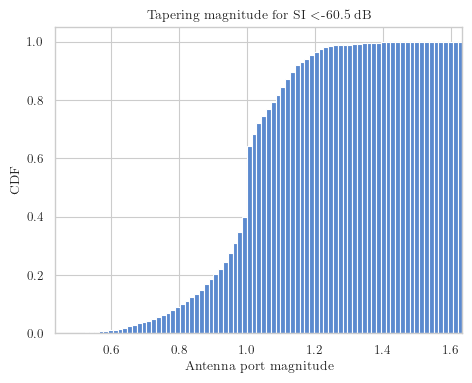

In [14]:
_ = plt.hist(tx_mag, bins=tx_codebooks.size//200,
             cumulative=True, density=True)
_ = plt.xlabel("Antenna port magnitude")
_ = plt.ylabel("CDF")
_ = plt.xlim(min(tx_mag), max(tx_mag))
_ = plt.title(rf"Tapering magnitude for SI \textless {si_cutoff:.1f} dB")

In [15]:
with np.load(res_path/"lagrange_codebooks.npz") as cb_data:
    si_achieved = cb_data["si_opt"]
    si_values = cb_data["si_tgt"]
    tx_codebooks = cb_data["tx"]
    L_t = tx_codebooks.shape[-1]
    rx_codebooks = cb_data["rx"]
    L_r = rx_codebooks.shape[-1]

    tx_dev = cb_data["tx_dev"]
    rx_dev = cb_data["rx_dev"]

    tx_degs = cb_data["tx_degrees"]
    rx_degs = cb_data["rx_degrees"]
    beam_degs = tx_degs

In [16]:
plot_si = -130
si_index = np.argmin(np.abs(np.array(si_values) - plot_si))
si_db_val = si_values[si_index]
tx_dev_val = tx_dev[si_index]
opt_tx_codebook = tx_codebooks[si_index,]
opt_rx_codebook = rx_codebooks[si_index,]

In [17]:
antenna_pattern = Antenna(params.antenna_pattern, polarization=params.antenna_polarization).patterns
rad_pattern = lambda x: sum(sum(np.abs(p)**2 for p in pat(np.pi/2, x)) for pat in antenna_pattern)

In [18]:
si_db_val

-130.48768567077357

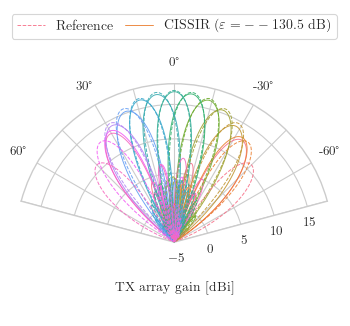

In [19]:
thetas = np.deg2rad(np.arange(-75, 80, 15))

offset, stride = 1, 2
f, ax = plt.subplots(subplot_kw={'projection': 'polar'})
tx_kwargs = dict(transmit=True, element_pattern=rad_pattern, axis=ax, r_lim=(-5, 18), alpha=0.9, linewidth=0.7, theta_lim=(-5*np.pi/12, 5*np.pi/12))
_ = plot_beamforming_polar(dft_tx_codebook[:, offset::stride], linestyle="--", color_palette="husl", **tx_kwargs, label="Reference", zorder=20)
_ = plot_beamforming_polar(opt_tx_codebook[:, offset::stride], color_palette="husl", **tx_kwargs,
                           label="Optimized", zorder=10)

ax.set_xticks(thetas)
xticks = ax.get_xticklabels()
_ = ax.set_xticklabels([tick if i % 2 == 1 else None for i, tick in enumerate(xticks)])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1]+handles[L_t//stride+1:L_t//stride+2], ["Reference", rf"CISSIR ($\varepsilon=-{si_db_val:.1f}$ dB)"],
                                                   # + r"$\sigma_{\mathrm{tx}}^2=" + f"{tx_dev_val:.1f}$ dB)"],
                                                   loc="upper center",
          ncol=2, prop={'size': 10}, columnspacing=0.8, 
          bbox_to_anchor=(0.5, 1.01)) #  prop={'size': 8}, )
ax.set_xlabel("TX array gain [dBi]") # , x=0.8, rotation=12)
ax.xaxis.labelpad = -25